In [2]:
import numpy as np
import imageio
import matplotlib.colors
from os import listdir
from os.path import isfile, join
import scipy, scipy.misc, scipy.signal


def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei + 4, wid + 4, ch))
    for i in range(ch):
        Img[:, :, i] = np.pad(img[:, :, i], (2, 2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:, :, 0] = hsv[:, :, 0] * 255
    hsv[:, :, 1] = hsv[:, :, 1] * 255
    hsv[hsv > 255] = 255
    hsv[hsv < 0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]])
    fv = fh.conj().T

    H = hsv[:, :, 0]
    S = hsv[:, :, 1]
    I = hsv[:, :, 2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh == 0] = 0.00001
    dIv[dIv == 0] = 0.00001
    dI = np.sqrt(dIh * 2 + dIv * 2).astype(np.uint32)
    di = dI[2:hei + 2, 2:wid + 2]

    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh == 0] = 0.00001
    dSv[dSv == 0] = 0.00001
    dS = np.sqrt(dSh * 2 + dSv * 2).astype(np.uint32)
    ds = dS[2:hei + 2, 2:wid + 2]

    h = H[2:hei + 2, 2:wid + 2]
    s = S[2:hei + 2, 2:wid + 2]
    i = I[2:hei + 2, 2:wid + 2].astype(np.uint8)

    Imean = scipy.signal.convolve2d(I, np.ones((5, 5)) / 25, mode='same')
    Smean = scipy.signal.convolve2d(S, np.ones((5, 5)) / 25, mode='same')

    Rho = np.zeros((hei + 4, wid + 4))
    for p in range(2, hei + 2):
        for q in range(2, wid + 2):
            tmpi = I[p - 2:p + 3, q - 2:q + 3]
            tmps = S[p - 2:p + 3, q - 2:q + 3]
            corre = np.corrcoef(tmpi.flatten('F'), tmps.flatten('F'))
            Rho[p, q] = corre[0, 1]

    rho = np.abs(Rho[2:hei + 2, 2:wid + 2])
    rho[np.isnan(rho)] = 0
    rd = (rho * ds).astype(np.uint32)
    Hist_I = np.zeros((256, 1))
    Hist_S = np.zeros((256, 1))

    for n in range(0, 255):
        temp = np.zeros(di.shape)
        temp[i == n] = di[i == n]
        Hist_I[n + 1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i == n] = rd[i == n]
        Hist_S[n + 1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S


def dhe(image, alpha=0.5):
    img = imageio.imread(join("Pict20", image))

    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha * hist_s + (1 - alpha) * hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)

    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    i = hsv[:, :, 2].astype(np.uint8)

    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0, 255):
        i_s[i == n] = s_r[n + 1] / 255.0
    i_s[i == 255] = 1
    hsi_o = np.stack((h, s, i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)

    result = result * 255
    result[result > 255] = 255
    result[result < 0] = 0
    return result.astype(np.uint8)

In [3]:
from dhe import *
from os import listdir
from os.path import isfile, join
import time
import imageio
import multiprocessing
from joblib import Parallel, delayed

def main():  
    files = [f for f in listdir("Pict20") if isfile(join("Pict20", f))]
    for img_name in files:
        
       
        start_time = time.time()
        dhe_img = Parallel(n_jobs=2)(delayed(dhe)(i) for i in files)
        end_time = time.time() - start_time
        
    print("Toal Time Taken =", end_time)


if __name__ == '__main__':
    main()

Toal Time Taken = 213.38571405410767


In [4]:
from dhe import *
from os import listdir
from os.path import isfile, join
import time
import imageio
import multiprocessing
from joblib import Parallel, delayed

def main():  
    files = [f for f in listdir("Pict20") if isfile(join("Pict20", f))]
    for img_name in files:
        
       
        start_time = time.time()
        dhe_img = Parallel(n_jobs=4)(delayed(dhe)(i) for i in files)
        end_time = time.time() - start_time
        
    print("Toal Time Taken =", end_time)


if __name__ == '__main__':
    main()

Toal Time Taken = 134.55625987052917


In [5]:
from dhe import *
from os import listdir
from os.path import isfile, join
import time
import imageio
import multiprocessing
from joblib import Parallel, delayed

def main():  
    files = [f for f in listdir("Pict20") if isfile(join("Pict20", f))]
    for img_name in files:
        
       
        start_time = time.time()
        dhe_img = Parallel(n_jobs=6)(delayed(dhe)(i) for i in files)
        end_time = time.time() - start_time
        
    print("Toal Time Taken =", end_time)


if __name__ == '__main__':
    main()

Toal Time Taken = 114.70044922828674


In [9]:
from dhe import *
from os import listdir
from os.path import isfile, join
import time
import imageio
import multiprocessing
from joblib import Parallel, delayed

def main():  
    files = [f for f in listdir("Pict20") if isfile(join("Pict20", f))]
    for img_name in files:
        
       
        start_time = time.time()
        dhe_img = Parallel(n_jobs=8)(delayed(dhe)(i) for i in files)
        end_time = time.time() - start_time
        
    print("Toal Time Taken =", end_time)


if __name__ == '__main__':
    main()

Toal Time Taken = 107.95438981056213


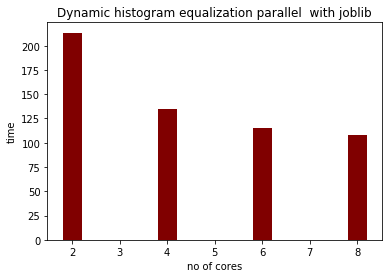

In [7]:
import numpy as np
import matplotlib.pyplot as plt
lst=[213.38571405410767,134.55625987052917,114.70044922828674,107.95438981056213]
n_of_c=[2,4,6,8]
plt.bar(n_of_c,lst, color ='maroon',
        width = 0.4)
 
plt.xlabel("no of cores")
plt.ylabel("time")
plt.title("Dynamic histogram equalization parallel  with joblib")
plt.show()